In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install transformers
!pip install datasets

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 42.5 MB/s 
     |████████████████████████████████| 182 kB 75.5 MB/s 
     |████████████████████████████████| 7.6 MB 53.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 27.2 MB/s 
     |████████████████████████████████| 212 kB 63.9 MB/s 
     |████████████████████████████████| 132 kB 71.7 MB/s 
     |████████████████████████████████| 127 kB 76.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import numpy as np
import pandas as pd 
from transformers import BertTokenizer, Trainer, BertForSequenceClassification, TrainingArguments, pipeline
from datasets import Dataset
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [ ]:
# tested in transformers==4.18.0, pytorch==1.7.1 
import torch
import transformers
torch.__version__, transformers.__version__

('1.13.0+cu116', '4.25.1')

In [ ]:
torch.cuda.is_available()

True

In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification
# tokenizer = AutoTokenizer.from_pretrained("snunlp/KR-FinBert")
# model = AutoModelForMaskedLM.from_pretrained("snunlp/KR-FinBert", num_labels=5)
tokenizer = AutoTokenizer.from_pretrained("snunlp/KR-FinBert-SC")
model = AutoModelForSequenceClassification.from_pretrained("snunlp/KR-FinBert-SC")

Downloading:   0%|          | 0.00/372 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/143k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/294k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/881 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/406M [00:00<?, ?B/s]

튜닝 데이터 준비

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/주가원인분석/df_kia_weekday.csv')
df_target = df[['content', 'target']]
df_target = df_target.rename(columns = {'content': 'sentence', 'target' : 'label'})
df_target

,sentence,label
0,국내완성차 11월 판매 76만2천967대전년비 8.4서울연합인포맥스 이민재 기자 ...,-1
1,"검찰, 에 건넨 특활비 추적해 유의미한 용처 파악서울연합뉴스 방현덕 기자 박근혜 ...",0
2,특징주현대차 3인방 내림세.. 판매부진에 파업 우려이데일리 함정선 기자 현대차그룹 ...,0
3,제네시스 80 디젤 출격임박수입차 수준 연비성능 뽑았다이데일리 노재웅 기자 의 고급...,0
4,이데일리 11월 건설 체감경기 악화정책금리 인상 영향이데일리 1. 최종구 창업중소기...,0
...,...,...
11521,"처벌로 못 줄인 산재정부 산재 정책, 기업 자율규제 중심으로 바뀐다이데일리 최정훈 ...",1
11522,프로필루크 동커볼케 현대자동차 사장이데일리 손의연 기자 그룹이 30일 최고창조책임자...,1
11523,"안정과 미래 동시에 챙긴 정의선, 현대차그룹 핀셋 인사종합이데일리 송승현 기자 올해...",1
11524,"코스피, 경기둔화 우려에 하락 출발2400선 턱걸이이데일리 양지윤 기자 코스피지수...",1


In [ ]:
target_dict = {'-2' : '0', '-1' : '1', '0' : '2', '1' : '3', '2' : '4', '3' : '5'}
df_target['label'] = df_target['label'].apply(lambda x : target_dict[str(x)])
df_target['label'] = df_target['label'].astype('int')
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11526 entries, 0 to 11525
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  11526 non-null  object
 1   label     11526 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 180.2+ KB


In [ ]:
df_target_len = df_target['sentence'].apply(len)
df_target_len.describe()

count    11526.000000
mean      1165.900833
std        741.837130
min         20.000000
25%        678.250000
50%       1060.000000
75%       1522.750000
max      12641.000000
Name: sentence, dtype: float64

In [ ]:
df_target['label'].value_counts()

2    4961
1    3313
3    3189
0      32
4      31
Name: label, dtype: int64

In [ ]:
target_dict2 = {'0' : '0', '1' : '0', '2' : '1', '3' : '2', '4' : '2'}
df_target_label3 = df_target.copy()
df_target_label3['label'] = df_target['label'].apply(lambda x : target_dict2[str(x)])
df_target_label3['label'] = df_target_label3['label'].astype('int')
df_target_label3

,sentence,label
0,국내완성차 11월 판매 76만2천967대전년비 8.4서울연합인포맥스 이민재 기자 ...,0
1,"검찰, 에 건넨 특활비 추적해 유의미한 용처 파악서울연합뉴스 방현덕 기자 박근혜 ...",1
2,특징주현대차 3인방 내림세.. 판매부진에 파업 우려이데일리 함정선 기자 현대차그룹 ...,1
3,제네시스 80 디젤 출격임박수입차 수준 연비성능 뽑았다이데일리 노재웅 기자 의 고급...,1
4,이데일리 11월 건설 체감경기 악화정책금리 인상 영향이데일리 1. 최종구 창업중소기...,1
...,...,...
11521,"처벌로 못 줄인 산재정부 산재 정책, 기업 자율규제 중심으로 바뀐다이데일리 최정훈 ...",2
11522,프로필루크 동커볼케 현대자동차 사장이데일리 손의연 기자 그룹이 30일 최고창조책임자...,2
11523,"안정과 미래 동시에 챙긴 정의선, 현대차그룹 핀셋 인사종합이데일리 송승현 기자 올해...",2
11524,"코스피, 경기둔화 우려에 하락 출발2400선 턱걸이이데일리 양지윤 기자 코스피지수...",2


In [ ]:
df_target_label3['label'].value_counts()

1    4961
0    3345
2    3220
Name: label, dtype: int64

(array([2.698e+03, 4.686e+03, 2.652e+03, 1.038e+03, 2.860e+02, 9.600e+01,
        3.200e+01, 1.700e+01, 6.000e+00, 6.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00]),
 array([   20.  ,   651.05,  1282.1 ,  1913.15,  2544.2 ,  3175.25,
         3806.3 ,  4437.35,  5068.4 ,  5699.45,  6330.5 ,  6961.55,
         7592.6 ,  8223.65,  8854.7 ,  9485.75, 10116.8 , 10747.85,
        11378.9 , 12009.95, 12641.  ]),
 <a list of 20 Patch objects>)

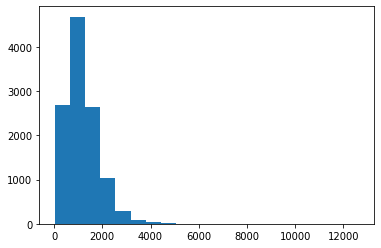

In [ ]:
plt.hist(df_target_len, bins=20)

In [ ]:
df_train, df_test = train_test_split(df_target_label3, test_size=0.1, random_state=2022, stratify= df_target_label3.label)
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=2022, stratify= df_train.label)
df_train.shape, df_val.shape, df_test.shape

((9335, 2), (1038, 2), (1153, 2))

In [ ]:
dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

dataset_train = dataset_train.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_val = dataset_val.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_test = dataset_test.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length' , max_length=128), batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

모델훈련

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy' : accuracy_score(predictions, labels)}

args = TrainingArguments(
        output_dir = 'temp/',
        evaluation_strategy = 'epoch',
        save_strategy = 'epoch',
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=30,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
)

trainer = Trainer(
        model=model,                         # the instantiated 🤗 Transformers model to be trained
        args=args,                  # training arguments, defined above
        train_dataset=dataset_train,         # training dataset
        eval_dataset=dataset_val,            # evaluation dataset
        compute_metrics=compute_metrics
)

trainer.train()   

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 9335
  Num Epochs = 30
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 8760
  Number of trainable parameters = 101403651


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.080509,0.453757
2,1.152600,1.068677,0.462428
3,1.152600,1.109914,0.492293
4,0.942000,1.323478,0.469171
5,0.942000,1.445160,0.480732
6,0.569000,1.911188,0.463391
7,0.257400,2.096154,0.458574
8,0.257400,2.439641,0.485549
9,0.135800,2.858745,0.467245
10,0.135800,3.033832,0.466281


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1038
  Batch size = 32
Saving model checkpoint to temp/checkpoint-292
Configuration saved in temp/checkpoint-292/config.json
Model weights saved in temp/checkpoint-292/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1038
  Batch size = 32
Saving model checkpoint to temp/checkpoint-584
Configuration saved in temp/checkpoint-5

TrainOutput(global_step=8760, training_loss=0.1983955827886111, metrics={'train_runtime': 6187.955, 'train_samples_per_second': 45.257, 'train_steps_per_second': 1.416, 'total_flos': 1.84212281586816e+16, 'train_loss': 0.1983955827886111, 'epoch': 30.0})

모델평가


In [ ]:
model.eval()
trainer.predict(dataset_test).metrics

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1153
  Batch size = 32


{'test_loss': 4.500539302825928,
 'test_accuracy': 0.4865568083261058,
 'test_runtime': 7.9188,
 'test_samples_per_second': 145.604,
 'test_steps_per_second': 4.672}

모델저장

In [ ]:
cd /content/drive/MyDrive/주가원인분석

/content/drive/MyDrive/주가원인분석


In [ ]:
trainer.save_model('finbert-sentiment2/')

Saving model checkpoint to finbert-sentiment2/
Configuration saved in finbert-sentiment2/config.json
Model weights saved in finbert-sentiment2/pytorch_model.bin


In [ ]:
model = BertForSequenceClassification.from_pretrained('finbert-sentiment2/',num_labels=3)
tokenizer = BertTokenizer.from_pretrained('yiyanghkust/finbert-pretrain')

loading configuration file finbert-sentiment2/config.json
Model config BertConfig {
  "_name_or_path": "snunlp/KR-FinBert-SC",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "negative",
    "1": "neutral",
    "2": "positive"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "negative": 0,
    "neutral": 1,
    "positive": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 20000
}

loading weights file finbert-

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--yiyanghkust--finbert-pretrain/snapshots/88ab954a39ea6d3ce2b62cff086dd5ad1172c664/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None


Downloading:   0%|          | 0.00/359 [00:00<?, ?B/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--yiyanghkust--finbert-pretrain/snapshots/88ab954a39ea6d3ce2b62cff086dd5ad1172c664/config.json
Model config BertConfig {
  "_name_or_path": "yiyanghkust/finbert-pretrain",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30873
}



In [ ]:
model.eval()
trainer = Trainer(
        model=model,                         # the instantiated 🤗 Transformers model to be trained
        args=args,                  # training arguments, defined above
        train_dataset=dataset_train,         # training dataset
        eval_dataset=dataset_val,            # evaluation dataset
        compute_metrics=compute_metrics
)
pred = trainer.predict(dataset_test)
pred

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1153
  Batch size = 32


PredictionOutput(predictions=array([[-5.5415835 ,  5.7482257 ,  0.5952219 ],
       [ 4.6697187 , -4.762782  , -0.20896119],
       [-4.7002826 ,  7.5463142 , -2.044448  ],
       ...,
       [-1.8167932 ,  4.4710464 , -2.2740226 ],
       [-1.3672231 ,  6.8574395 , -5.2442117 ],
       [-3.649722  ,  7.7413197 , -3.601398  ]], dtype=float32), label_ids=array([2, 1, 0, ..., 2, 1, 0]), metrics={'test_loss': 4.500539302825928, 'test_accuracy': 0.4865568083261058, 'test_runtime': 7.9085, 'test_samples_per_second': 145.792, 'test_steps_per_second': 4.678})

In [ ]:
np.argmax(pred.predictions, axis=1)

array([1, 0, 1, ..., 1, 1, 1])

In [ ]:
df_test2 =df_test.copy()
df_test2['pred2'] = np.argmax(pred.predictions, axis=1)
df_test2

,sentence,label,pred2
1680,직업방송 탄 기아차 채용설명회취준생 관심폭발.서울연합인포맥스 황병극 기자 한국직업...,2,1
7816,2패 뒤 반격하면 장기전 가능성3연승 땐 100 확률로 40서울연합뉴스 김동찬 기자...,1,0
10230,"가족 간 정 느끼며, 아동권 보장 외치며어린이마라톤 3인3색서울연합뉴스 이상서 기자...",0,1
6176,"코스피, 외국인 매도 전환에 장중 1대 하락이데일리 최정희 기자 코스피 지수가 외국...",2,2
3552,포토 기아대책 기대봉사단 대회이데일리 김태형 기자 국제구호단체 기아대책회장 유원식 ...,2,2
...,...,...,...
5621,"현대차그룹, 저신용 부품사 금융지원 동참1천200억 출연서울연합인포맥스 이윤구 기자...",0,0
3666,"기아차, 누계판매 4천대 달성한 10번째 그랜드 마스터 배출이데일리 오토in 카가이...",2,1
7057,완성차 1월 실적 회복세르노삼성 빼고 전년 증가종합이데일리 손의연 기자 국내 완성차...,2,1
3301,"기아차, 5월 내수 4만3000대..전년 8.6이데일리 이소현 기자 는 지난 5월 ...",1,1


In [ ]:
for idx in df_test2.index:
    if df_test2.loc[idx, 'label'] == df_test2.loc[idx, 'pred2']:
        df_test2.loc[idx, 'pred_tf'] = True
    else :
        df_test2.loc[idx, 'pred_tf'] = False
df_test2

,sentence,label,pred2,pred_tf
1680,직업방송 탄 기아차 채용설명회취준생 관심폭발.서울연합인포맥스 황병극 기자 한국직업...,2,1,False
7816,2패 뒤 반격하면 장기전 가능성3연승 땐 100 확률로 40서울연합뉴스 김동찬 기자...,1,0,False
10230,"가족 간 정 느끼며, 아동권 보장 외치며어린이마라톤 3인3색서울연합뉴스 이상서 기자...",0,1,False
6176,"코스피, 외국인 매도 전환에 장중 1대 하락이데일리 최정희 기자 코스피 지수가 외국...",2,2,True
3552,포토 기아대책 기대봉사단 대회이데일리 김태형 기자 국제구호단체 기아대책회장 유원식 ...,2,2,True
...,...,...,...,...
5621,"현대차그룹, 저신용 부품사 금융지원 동참1천200억 출연서울연합인포맥스 이윤구 기자...",0,0,True
3666,"기아차, 누계판매 4천대 달성한 10번째 그랜드 마스터 배출이데일리 오토in 카가이...",2,1,False
7057,완성차 1월 실적 회복세르노삼성 빼고 전년 증가종합이데일리 손의연 기자 국내 완성차...,2,1,False
3301,"기아차, 5월 내수 4만3000대..전년 8.6이데일리 이소현 기자 는 지난 5월 ...",1,1,True


In [ ]:
df_test2.to_csv('test_finbert_3label_ep30.csv', index=False)

In [ ]:
df_test2['pred_tf'].sum() / len(df_test2)

0.4865568083261058